# Alzheimer Classifier

In this notebook, We will build a classifier to predict whether a patient has Alzheimer's disease or not. I will use a dataset that contains MRI images of the brain. The implementation is based on this [paper](https://www.researchgate.net/publication/349874169_A_CNN_based_framework_for_classification_of_Alzheimer's_disease).

# Introduction

Alzheimer's disease (AD) is a neurodegenerative disorder that causes memory loss and cognitive decline. It is the most common cause of dementia, accounting for 60-70% of cases. The exact cause of AD is unknown, but it is believed to be a combination of genetic, environmental, and lifestyle factors. There is currently no cure for AD, but early detection and treatment can help slow the progression of the disease. So the need for an accurate and reliable method for diagnosing AD is crucial.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tqdm
import os
import sys
from PIL import Image
import cv2
from collections import Counter, defaultdict
import pickle
import visualkeras
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import data as tfdata
from tensorflow import image as tfimage
from tensorflow import io as tfio

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization, ReLU, Conv2D, MaxPooling2D, Lambda
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical, plot_model, img_to_array, normalize
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import GlorotUniform, GlorotNormal, HeNormal, HeUniform
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

## Dataset

The dataset used in this notebook is the [ADNI](https://www.kaggle.com/datasets/subhranilsarkar/alzheimer-s-disease-neuroimaging-adni-dataset) dataset from Kaggle. The dataset contains MRI images of the brain from patients with Alzheimer's disease and healthy controls. The dataset is divided into two classes: Mild Cognitive Impairment (MCI), and Alzheimer's disease (AD). The dataset contains a total of 1654 images, with 965 images from AD patients and 689 images from MCIs. For pre-processing, since most of the things are already done, we just need to resize the images to a fixed size.

In [2]:
def read_images_of(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (256, 256))
            image = image / 255.0
            if image is not None:
                images.append(image)
    images = np.array(images)
    return images


ad = read_images_of("../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD")
mci = read_images_of("../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI")

In [3]:
encoder = OneHotEncoder(sparse_output=False)

data = np.concatenate((ad, mci), axis=0)
ad_label = np.ones(ad.shape[0], dtype=int)
mci_label = np.zeros(mci.shape[0], dtype=int)
labels = np.concatenate((ad_label, mci_label), axis=0).reshape(-1, 1)


shuffle_indices = np.random.permutation(data.shape[0])
data = data[shuffle_indices]
labels = labels[shuffle_indices]
labels = encoder.fit_transform(labels)

In [4]:
X_train_2_10_th, X_test_2_10_th, y_train_2_10_th, y_test_2_10_th = train_test_split(data, labels, test_size=0.2, random_state=7)
X_train_3_10_th, X_test_3_10_th, y_train_3_10_th, y_test_3_10_th = train_test_split(data, labels, test_size=0.3, random_state=7)
X_train_5_10_th, X_test_5_10_th, y_train_5_10_th, y_test_5_10_th = train_test_split(data, labels, test_size=0.5, random_state=7)

## Data Augmentation

Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the images. This helps to improve the generalization of the model and reduce overfitting. We will apply random rotations, flips, shifts, and zooms to the images.

In [5]:
train_datagen_2_10_th = ImageDataGenerator().flow(
    x=X_train_2_10_th,
    y=y_train_2_10_th,
    batch_size=16
)

train_datagen_3_10_th = ImageDataGenerator().flow(
    x=X_train_3_10_th,
    y=y_train_3_10_th,
    batch_size=16
)

train_datagen_5_10_th = ImageDataGenerator().flow(
    x=X_train_5_10_th,
    y=y_train_5_10_th,
    batch_size=16
)

test_datagen_2_th = ImageDataGenerator().flow(
    x=X_test_2_10_th,
    y=y_test_2_10_th,
    batch_size=16
)

test_datagen_3_th = ImageDataGenerator().flow(
    x=X_test_3_10_th,
    y=y_test_3_10_th,
    batch_size=16
)

test_datagen_5_th = ImageDataGenerator().flow(
    x=X_test_5_10_th,
    y=y_test_5_10_th,
    batch_size=16
)

## Implementation

### Gloroit Initialization

The Glorot initialization, also known as Xavier initialization, is a method used to initialize the weights of a neural network. It is based on the idea that the weights should be initialized in such a way that the variance of the input and output of each layer is the same. This helps to prevent the gradients from becoming too large or too small during training. For a fully connected layer with input size `n_in` and output size `n_out`, the weights `W` are initialized according to a uniform distribution in the range:

$$
W \sim U\left[-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right]
$$

Here, `U[a, b]` denotes a uniform distribution in the range `[a, b]`. This initialization helps to avoid vanishing or exploding gradients at the start of the training process.


### Activation Function

We will use the ReLU activation function in the hidden layers of the network. The ReLU function is a non-linear activation function that introduces non-linearity into the network and helps to learn complex patterns in the data. tanh and sigmoid activation functions are also used in the network. For output layer we will use softmax activation function.

Formulas for each of the activation functions are as follows:

$$ReLU(x) = max(0, x)$$

$$tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$

$$softmax(x) = \frac{e^{x_{i}}}{\sum_{j} e^{x_{j}}}$$

### Loss Function

We will use the categorical cross-entropy loss function to train the model. The categorical cross-entropy loss function is used for multi-class classification problems and measures the difference between the predicted probability distribution and the true probability distribution of the classes. The formula for the categorical cross-entropy loss function is as follows:

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i = 1}^{N} \sum_{j = 1}^{C} (y_{i} = j) log(\hat{y}_{i})$$

Where $y$ is the true probability distribution, $\hat{y}$ is the predicted probability distribution, and $N$ is the number of classes.

Using Cross-Entropy loss function after the softmax layer speeds the convergence of the neural network due to the gradient vanishing problem.


Another possible loss function is the negative log-likelihood loss function. The negative log-likelihood loss function is used for multi-class classification problems and measures the difference between the predicted probability distribution and the true probability distribution of the classes. The formula for the negative log-likelihood loss function is as follows:

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i} log(\hat{y}_{i})$$

Where $y$ is the true probability distribution, $\hat{y}$ is the predicted probability distribution, and $N$ is the number of classes.

The reason we chose the categorical cross-entropy loss function is that it is more stable and faster to converge than the negative log-likelihood loss function.

### Optimizer

We will use the Adam optimizer to train the model. The Adam optimizer is an adaptive learning rate optimization algorithm that combines the advantages of two other popular optimization algorithms: AdaGrad and RMSProp. The Adam optimizer adapts the learning rate for each parameter based on the first and second moments of the gradients. This helps to speed up the convergence of the model and improve its performance.

### Regularization

We will use L2 regularization to prevent overfitting in the model. L2 regularization adds a penalty term to the loss function that penalizes large weights. This helps to prevent the model from fitting the noise in the training data and improves its generalization performance. The L2 regularization term is given by:

$$L2 = \lambda \sum_{i} w_{i}^{2}$$

Where $\lambda$ is the regularization strength and $w_{i}$ are the weights of the model.

### Dropout

We will use dropout regularization to prevent overfitting in the model. Dropout is a technique that randomly sets a fraction of the input units to zero during training. This helps to prevent the model from relying too much on any single input unit and improves its generalization performance. We will apply dropout to the hidden layers of the network.

### Batch Normalization

We will use batch normalization to improve the training of the model. Batch normalization is a technique that normalizes the input to each layer of the network to have zero mean and unit variance. This helps to stabilize the training process and speed up convergence. We will apply batch normalization to the hidden layers of the network.

### Model Architecture

The model architecture consists of a series of convolutional layers followed by max-pooling layers. The convolutional layers extract features from the input images, while the max-pooling layers downsample the feature maps to reduce the spatial dimensions. The output of the convolutional layers is flattened and passed through a series of fully connected layers to make the final prediction. The model uses ReLU activation functions in the hidden layers and softmax activation function in the output layer. The model is trained using the categorical cross-entropy loss function and the Adam optimizer.

The model architecture is as follows:

1.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
2.  Batch Normalization
3.  ReLU Activation
4.  Dropout (0.5)
5.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
6.  Batch Normalization
7.  ReLU Activation
8.  Max Pooling (pool size 2x2, stride 2x2)
9.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
10. Batch Normalization
11. ReLU Activation
12. Dropout (0.5)
13. Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
14. Batch Normalization
15. ReLU Activation
16. Max Pooling (pool size 2x2, stride 2x2)
17. Flatten
18. Fully Connected Layer (128 units)
19. Batch Normalization
20. ReLU Activation
21. Dropout (0.5)
22. Fully Connected Layer (64 units)
23. Batch Normalization
24. ReLU Activation
25. Dropout (0.5)
26. Fully Connected Layer (2 units)
27. Softmax Activation
28. Output Layer
29. Categorical Cross-Entropy Loss Function
30. Adam Optimizer

In [14]:
initializer = GlorotUniform(seed=42)
regularizer = l2(0.01)

In [7]:
proposed_model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(
        128,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        64,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        2,
        activation="softmax",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
])

proposed_model.compile(optimizer=Adam(learning_rate=.1e-3), loss=categorical_crossentropy, metrics=["accuracy"])

In [8]:
proposed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 32)      0         
                                                        

We will also test two other models, with different architectures, to compare the performance of the models.

In [9]:
testing_model_1 = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(
        128,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dense(
        2,
        activation="softmax",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
])

testing_model_1.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=categorical_crossentropy,
    metrics=["accuracy"],
)

In [10]:
testing_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [11]:
testing_model_2 = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(
        128,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dense(
        64,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dense(
        2,
        activation="softmax",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
])

testing_model_2.compile(optimizer=Adam(learning_rate=1e-3), loss=categorical_crossentropy, metrics=["accuracy"])

In [12]:
testing_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 508032)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               65028224  
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                      

## Analysis

We will train the model on the training set and evaluate its performance on the testing set. We will calculate the accuracy, precision, recall, and F1 score of the model. We will also plot the confusion matrix to visualize the performance of the model. ROC curve and AUC score will also be calculated to evaluate the performance of the model.

The formulas for accuracy, precision, recall, and F1 score are as follows:

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

$$Precision = \frac{TP}{TP + FP}$$

$$Recall = \frac{TP}{TP + FN}$$

$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

Where $TP$ is the number of true positives, $TN$ is the number of true negatives, $FP$ is the number of false positives, and $FN$ is the number of false negatives.

ROC curve is a graphical representation of the true positive rate (sensitivity) versus the false positive rate (1-specificity) for a binary classification problem. The AUC score is the area under the ROC curve and provides a measure of the model's performance.

AUC score ranges from 0 to 1, where 0 indicates a poor model and 1 indicates a perfect model.

In [13]:
history_proposed_model = proposed_model.fit(
    train_datagen_2_10_th,
    epochs=25,
    steps_per_epoch=50,
    batch_size=16,
    validation_data=test_datagen_2_th,
)

Epoch 1/25
50/50 [==============================] - 18s 103ms/step - loss: 4.3300 - accuracy: 0.5497 - val_loss: 3.6051 - val_accuracy: 0.6224
Epoch 2/25
50/50 [==============================] - 4s 82ms/step - loss: 3.2868 - accuracy: 0.5723 - val_loss: 3.0551 - val_accuracy: 0.6284
Epoch 3/25
50/50 [==============================] - 4s 83ms/step - loss: 2.8360 - accuracy: 0.6352 - val_loss: 2.7376 - val_accuracy: 0.6405
Epoch 4/25
50/50 [==============================] - 4s 83ms/step - loss: 2.5843 - accuracy: 0.6138 - val_loss: 2.5076 - val_accuracy: 0.6465
Epoch 5/25
50/50 [==============================] - 4s 83ms/step - loss: 2.3171 - accuracy: 0.7000 - val_loss: 2.3007 - val_accuracy: 0.6918
Epoch 6/25
50/50 [==============================] - 4s 83ms/step - loss: 2.1285 - accuracy: 0.7175 - val_loss: 2.1211 - val_accuracy: 0.7100
Epoch 7/25
50/50 [==============================] - 4s 83ms/step - loss: 2.0140 - accuracy: 0.7006 - val_loss: 2.0039 - val_accuracy: 0.6949
Epoch 8/25


In [27]:
history_testing_model_1 = testing_model_1.fit(
    train_datagen_2_10_th,
    epochs=25,
    steps_per_epoch=50,
    batch_size=16,
    validation_data=test_datagen_2_th,
)

Epoch 1/25
50/50 [==============================] - 2s 42ms/step - loss: 1.4627 - accuracy: 0.6679 - val_loss: 0.9891 - val_accuracy: 0.7039
Epoch 2/25
50/50 [==============================] - 2s 41ms/step - loss: 0.9156 - accuracy: 0.6988 - val_loss: 0.9505 - val_accuracy: 0.6767
Epoch 3/25
50/50 [==============================] - 2s 40ms/step - loss: 0.8619 - accuracy: 0.7400 - val_loss: 0.8583 - val_accuracy: 0.6828
Epoch 4/25
50/50 [==============================] - 2s 39ms/step - loss: 0.7359 - accuracy: 0.7912 - val_loss: 0.7858 - val_accuracy: 0.7311
Epoch 5/25
50/50 [==============================] - 2s 38ms/step - loss: 0.7466 - accuracy: 0.7962 - val_loss: 0.8268 - val_accuracy: 0.7160
Epoch 6/25
50/50 [==============================] - 2s 39ms/step - loss: 0.6881 - accuracy: 0.8138 - val_loss: 0.7393 - val_accuracy: 0.7825
Epoch 7/25
50/50 [==============================] - 2s 38ms/step - loss: 0.6600 - accuracy: 0.8338 - val_loss: 0.7114 - val_accuracy: 0.7855
Epoch 8/25
50

In [30]:
history_testing_model_2 = testing_model_2.fit(
    train_datagen_2_10_th,
    epochs=25,
    steps_per_epoch=50,
    batch_size=16,
    validation_data=test_datagen_2_th,
)

Epoch 1/25
50/50 [==============================] - 6s 91ms/step - loss: 3.3914 - accuracy: 0.6264 - val_loss: 1.8081 - val_accuracy: 0.6616
Epoch 2/25
50/50 [==============================] - 4s 72ms/step - loss: 1.4886 - accuracy: 0.6453 - val_loss: 1.2662 - val_accuracy: 0.6828
Epoch 3/25
50/50 [==============================] - 3s 63ms/step - loss: 1.2016 - accuracy: 0.6478 - val_loss: 1.1612 - val_accuracy: 0.6224
Epoch 4/25
50/50 [==============================] - 3s 67ms/step - loss: 1.0548 - accuracy: 0.7050 - val_loss: 1.0363 - val_accuracy: 0.7039
Epoch 5/25
50/50 [==============================] - 3s 68ms/step - loss: 1.0420 - accuracy: 0.7094 - val_loss: 1.0179 - val_accuracy: 0.7372
Epoch 6/25
50/50 [==============================] - 4s 72ms/step - loss: 0.9930 - accuracy: 0.7225 - val_loss: 1.0857 - val_accuracy: 0.6103
Epoch 7/25
50/50 [==============================] - 4s 76ms/step - loss: 0.9140 - accuracy: 0.7875 - val_loss: 0.9477 - val_accuracy: 0.7553
Epoch 8/25
50

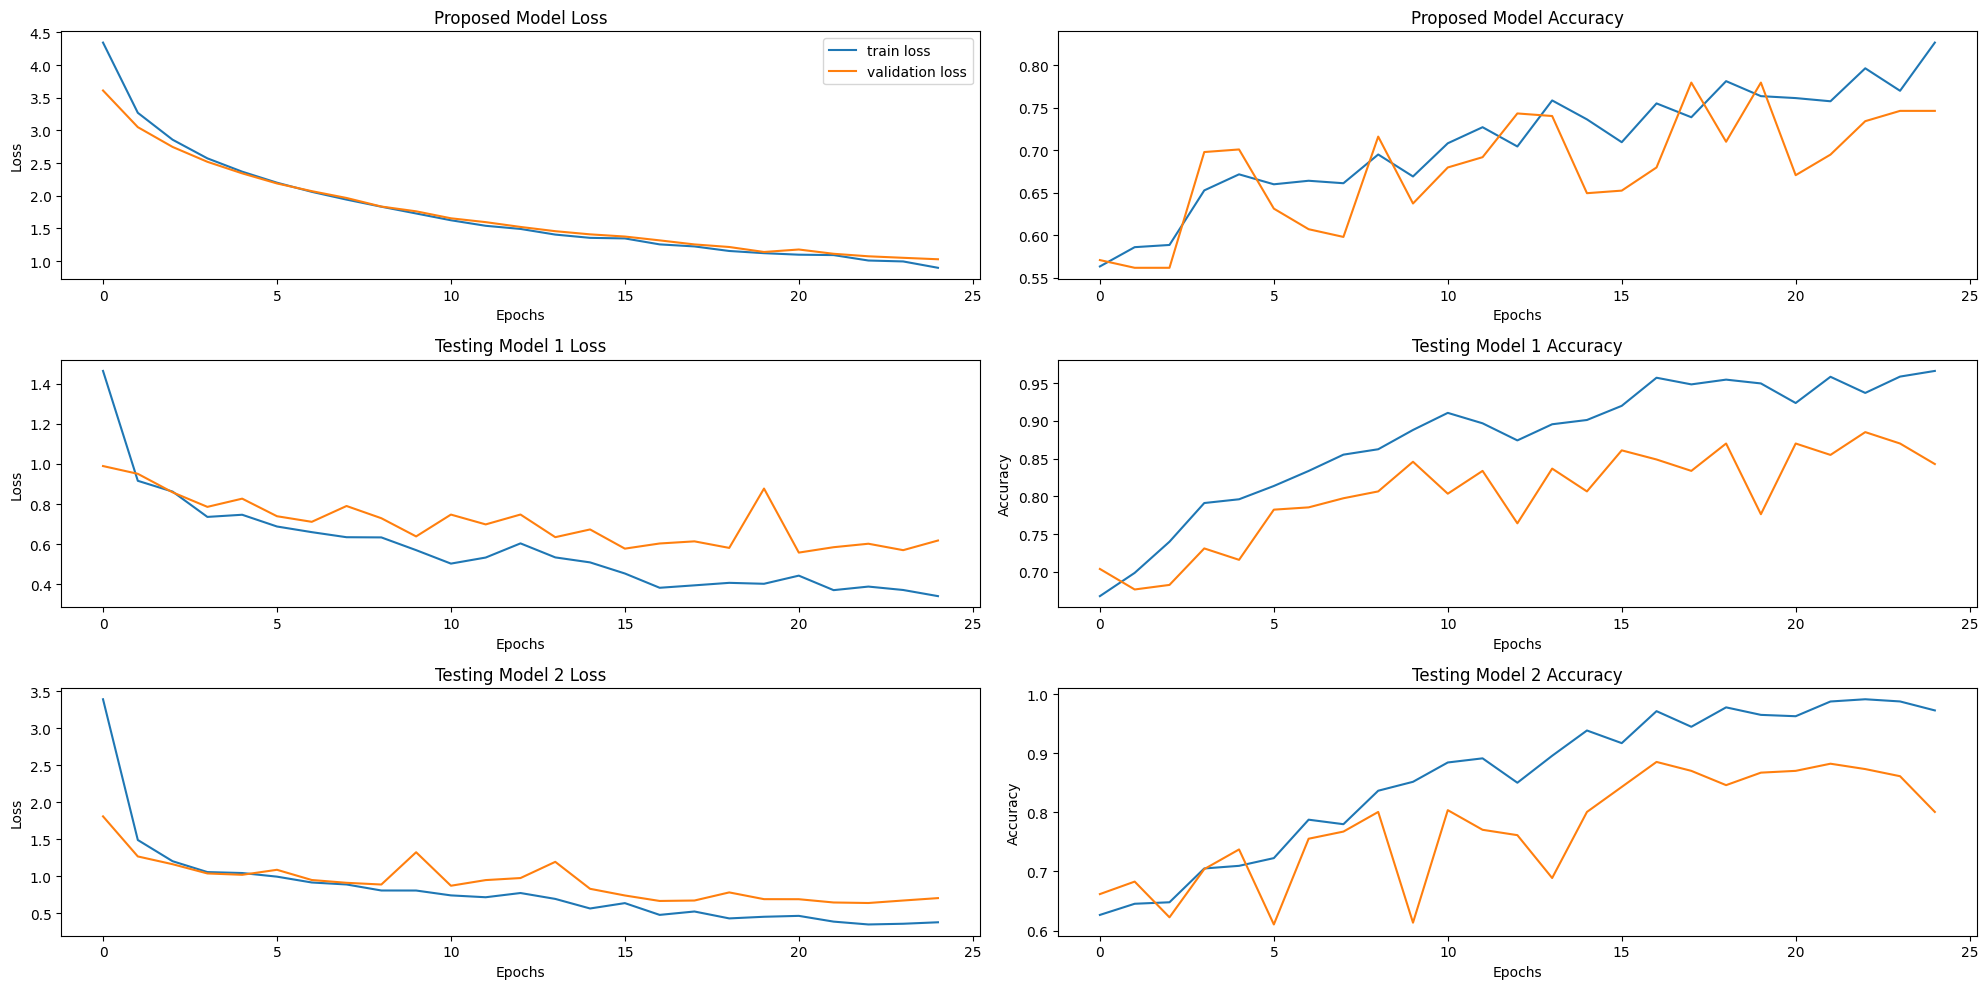

In [35]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
plt.plot(history_proposed_model.history["loss"], label="train loss")
plt.plot(history_proposed_model.history["val_loss"], label="validation loss")
plt.title("Proposed Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(history_proposed_model.history["accuracy"], label="train accuracy")
plt.plot(history_proposed_model.history["val_accuracy"], label="validation accuracy")
plt.title("Proposed Model Accuracy")
plt.xlabel("Epochs")

plt.subplot(3, 2, 3)
plt.plot(history_testing_model_1.history["loss"], label="train loss")
plt.plot(history_testing_model_1.history["val_loss"], label="validation loss")
plt.title("Testing Model 1 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(3, 2, 4)
plt.plot(history_testing_model_1.history["accuracy"], label="train accuracy")
plt.plot(history_testing_model_1.history["val_accuracy"], label="validation accuracy")
plt.title("Testing Model 1 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 5)
plt.plot(history_testing_model_2.history["loss"], label="train loss")
plt.plot(history_testing_model_2.history["val_loss"], label="validation loss")
plt.title("Testing Model 2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(3, 2, 6)
plt.plot(history_testing_model_2.history["accuracy"], label="train accuracy")
plt.plot(history_testing_model_2.history["val_accuracy"], label="validation accuracy")
plt.title("Testing Model 2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [21]:
def analyze(model, y_test, x_test = X_test_2_10_th):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    print(classification_report(y_test, y_pred))
    confusion_matrix_proposed_model = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix_proposed_model, display_labels=["AD", "MCI"]).plot(cmap="Blues")

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    plt.figure()
    plt.step(recall, precision, where="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall curve: AP={0:0.2f}".format(average_precision))
    plt.show()
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
    print(f"Average Precision Score: {average_precision_score(y_test, y_pred)}")

11/11 [==============================] - 1s 33ms/step
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       126
           1       0.95      0.87      0.91       205

    accuracy                           0.89       331
   macro avg       0.88      0.90      0.89       331
weighted avg       0.90      0.89      0.89       331



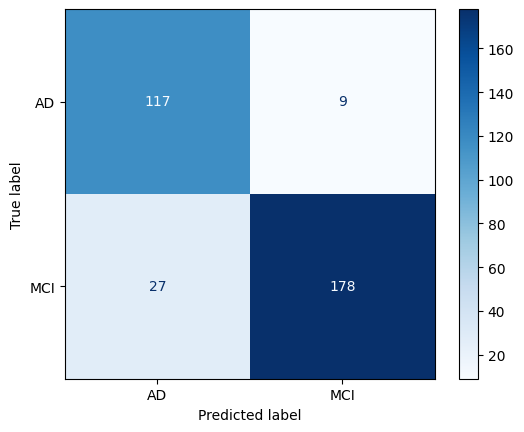

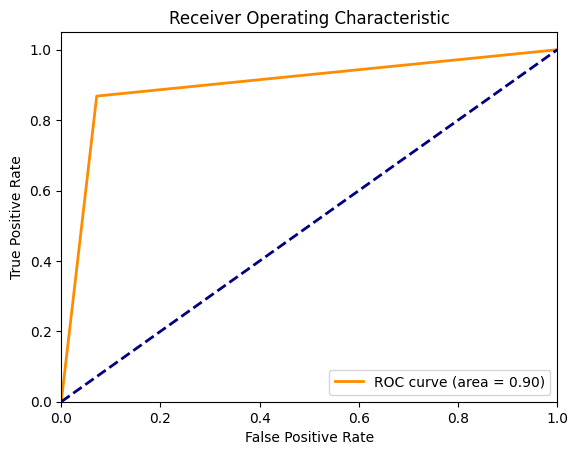

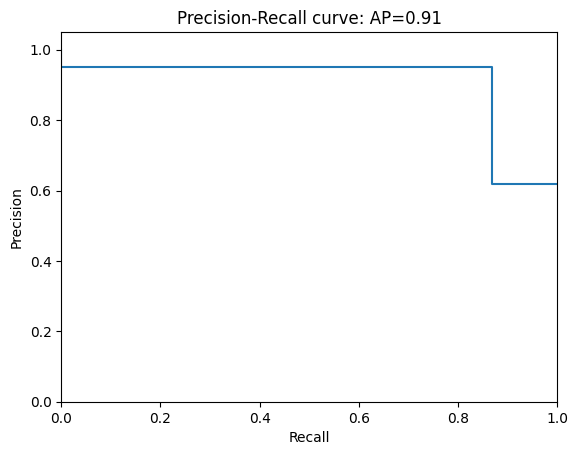

Accuracy: 0.8912386706948641
Precision: 0.9518716577540107
Recall: 0.8682926829268293
F1 Score: 0.9081632653061225
ROC AUC Score: 0.8984320557491289
Average Precision Score: 0.9080741924920905


In [ ]:
analyze(proposed_model, y_test_2_10_th)

11/11 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       142
           1       0.82      0.93      0.87       189

    accuracy                           0.84       331
   macro avg       0.85      0.83      0.84       331
weighted avg       0.85      0.84      0.84       331



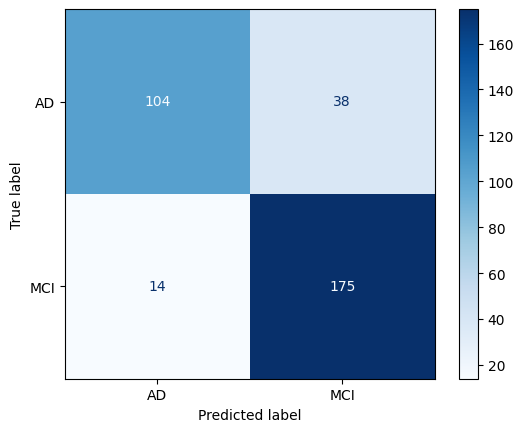

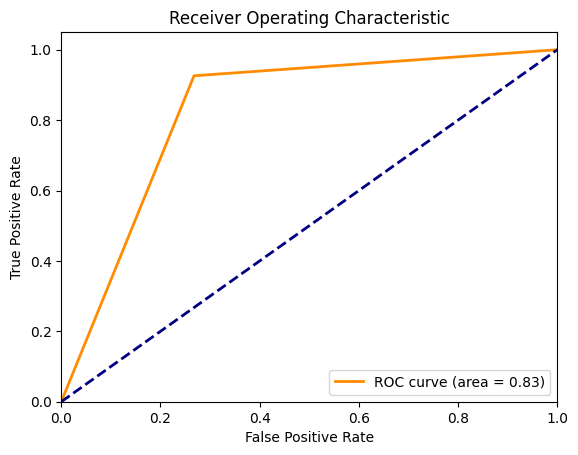

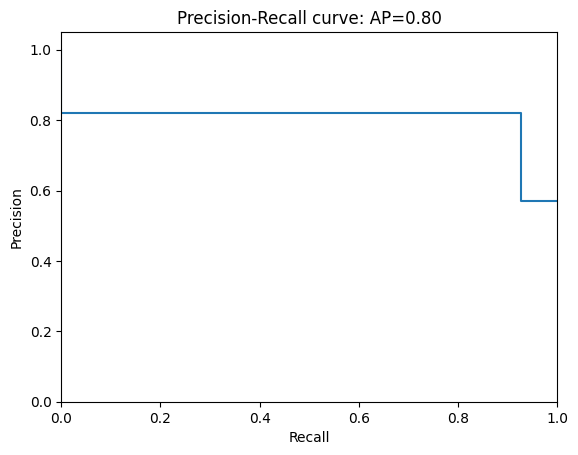

Accuracy: 0.8429003021148036
Precision: 0.8215962441314554
Recall: 0.9259259259259259
F1 Score: 0.8706467661691543
ROC AUC Score: 0.8291601460615545
Average Precision Score: 0.8030333355922338


In [53]:
analyze(testing_model_1, y_test_2_10_th)

11/11 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       142
           1       0.89      0.74      0.81       189

    accuracy                           0.80       331
   macro avg       0.81      0.81      0.80       331
weighted avg       0.82      0.80      0.80       331



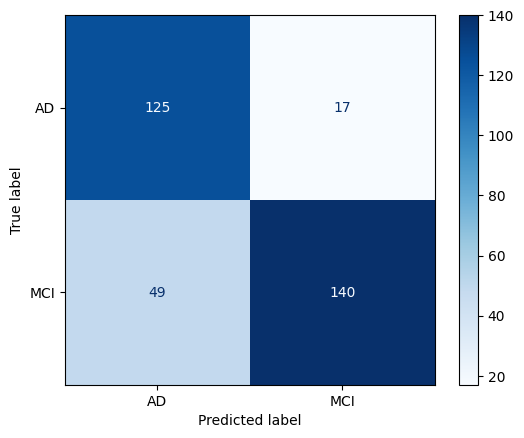

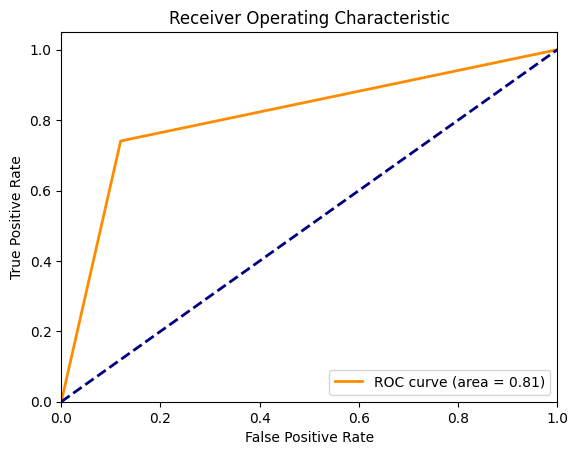

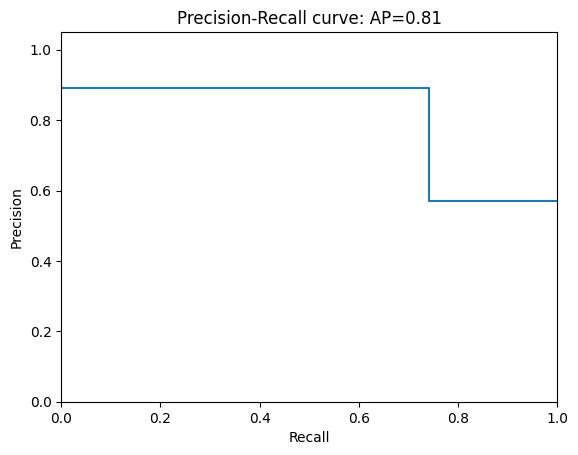

Accuracy: 0.8006042296072508
Precision: 0.89171974522293
Recall: 0.7407407407407407
F1 Score: 0.8092485549132948
ROC AUC Score: 0.810511215440793
Average Precision Score: 0.8085693983860127


In [54]:
analyze(testing_model_2, y_test_2_10_th)

In [18]:
proposed_model_with_3_10_th = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(
        128,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        64,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        2,
        activation="softmax",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
])

proposed_model_with_3_10_th.compile(optimizer=Adam(learning_rate=.1e-3), loss=categorical_crossentropy, metrics=["accuracy"])

In [19]:
proposed_model_with_3_10_th_history = proposed_model_with_3_10_th.fit(
    train_datagen_3_10_th,
    epochs=25,
    steps_per_epoch=50,
    batch_size=16,
    validation_data=test_datagen_3_th
)

Epoch 1/25
50/50 [==============================] - 8s 143ms/step - loss: 4.2185 - accuracy: 0.5843 - val_loss: 3.4863 - val_accuracy: 0.6117
Epoch 2/25
50/50 [==============================] - 6s 119ms/step - loss: 3.1550 - accuracy: 0.6020 - val_loss: 2.9398 - val_accuracy: 0.6499
Epoch 3/25
50/50 [==============================] - 6s 114ms/step - loss: 2.7321 - accuracy: 0.6692 - val_loss: 2.6325 - val_accuracy: 0.6398
Epoch 4/25
50/50 [==============================] - 6s 112ms/step - loss: 2.4752 - accuracy: 0.6312 - val_loss: 2.4132 - val_accuracy: 0.7163
Epoch 5/25
50/50 [==============================] - 6s 115ms/step - loss: 2.2738 - accuracy: 0.6475 - val_loss: 2.2340 - val_accuracy: 0.6439
Epoch 6/25
50/50 [==============================] - 6s 114ms/step - loss: 2.0816 - accuracy: 0.6844 - val_loss: 2.0554 - val_accuracy: 0.6922
Epoch 7/25
50/50 [==============================] - 5s 109ms/step - loss: 1.9616 - accuracy: 0.6755 - val_loss: 1.9604 - val_accuracy: 0.7686
Epoch 

16/16 [==============================] - 1s 58ms/step
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       193
           1       0.86      0.70      0.78       304

    accuracy                           0.75       497
   macro avg       0.75      0.76      0.75       497
weighted avg       0.78      0.75      0.75       497



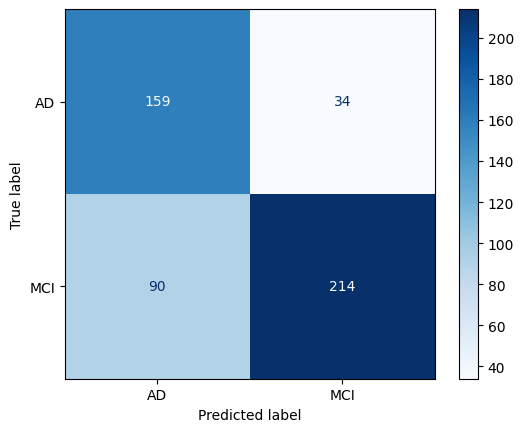

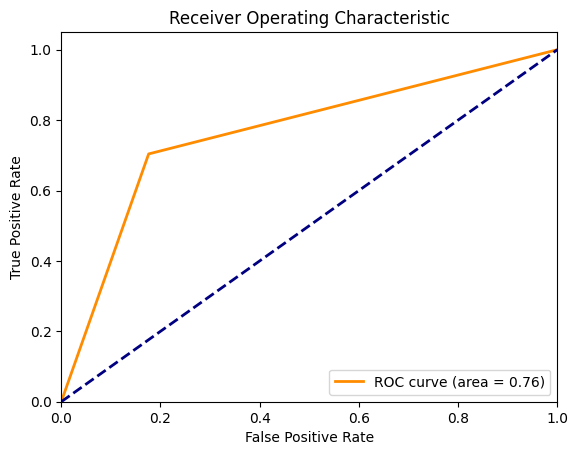

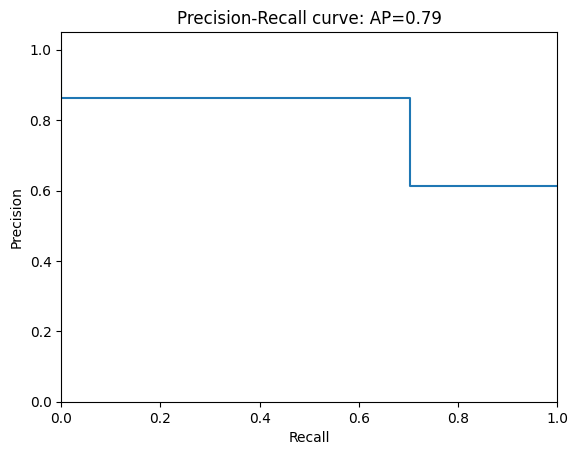

Accuracy: 0.7505030181086519
Precision: 0.8629032258064516
Recall: 0.7039473684210527
F1 Score: 0.7753623188405797
ROC AUC Score: 0.7638907826561222
Average Precision Score: 0.7885249741231771


In [22]:
analyze(proposed_model_with_3_10_th, y_test_3_10_th, X_test_3_10_th)

In [23]:
proposed_model_with_5_10_th = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(
        128,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        64,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        2,
        activation="softmax",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
])

proposed_model_with_5_10_th.compile(optimizer=Adam(learning_rate=.1e-3), loss=categorical_crossentropy, metrics=["accuracy"])

In [24]:
proposed_model_with_5_10_th_history = proposed_model_with_5_10_th.fit(
    train_datagen_5_10_th,
    epochs=25,
    steps_per_epoch=50,
    batch_size=16,
    validation_data=test_datagen_5_th
)

Epoch 1/25
50/50 [==============================] - 11s 212ms/step - loss: 4.1969 - accuracy: 0.5698 - val_loss: 3.4873 - val_accuracy: 0.6022
Epoch 2/25
50/50 [==============================] - 6s 121ms/step - loss: 3.1630 - accuracy: 0.5736 - val_loss: 2.9452 - val_accuracy: 0.5961
Epoch 3/25
50/50 [==============================] - 6s 119ms/step - loss: 2.7424 - accuracy: 0.6314 - val_loss: 2.6406 - val_accuracy: 0.6614
Epoch 4/25
50/50 [==============================] - 6s 118ms/step - loss: 2.4501 - accuracy: 0.6755 - val_loss: 2.4128 - val_accuracy: 0.6566
Epoch 5/25
50/50 [==============================] - 6s 115ms/step - loss: 2.2540 - accuracy: 0.6453 - val_loss: 2.2266 - val_accuracy: 0.7291
Epoch 6/25
50/50 [==============================] - 6s 114ms/step - loss: 2.0951 - accuracy: 0.6604 - val_loss: 2.0825 - val_accuracy: 0.6578
Epoch 7/25
50/50 [==============================] - 9s 172ms/step - loss: 1.9166 - accuracy: 0.7258 - val_loss: 1.9337 - val_accuracy: 0.7449
Epoch

26/26 [==============================] - 1s 47ms/step
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       341
           1       0.80      0.84      0.82       486

    accuracy                           0.78       827
   macro avg       0.78      0.77      0.78       827
weighted avg       0.78      0.78      0.78       827



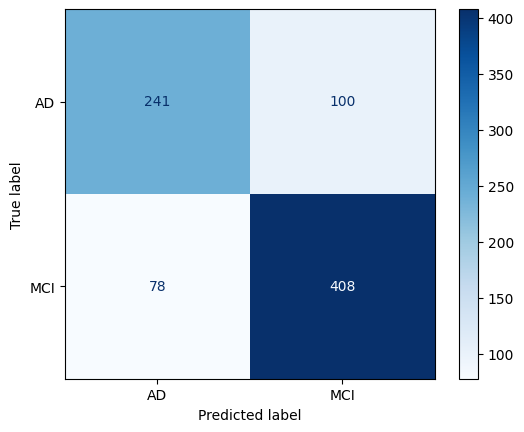

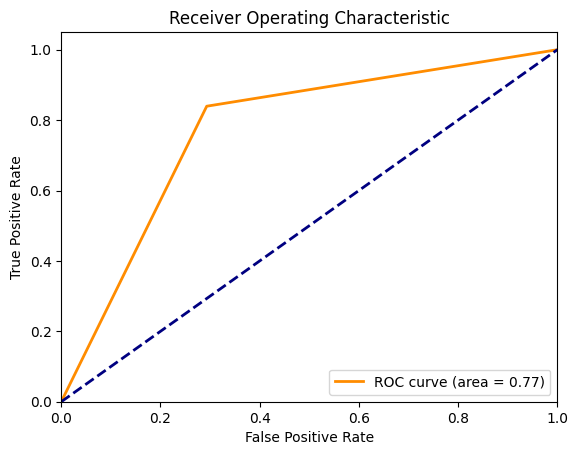

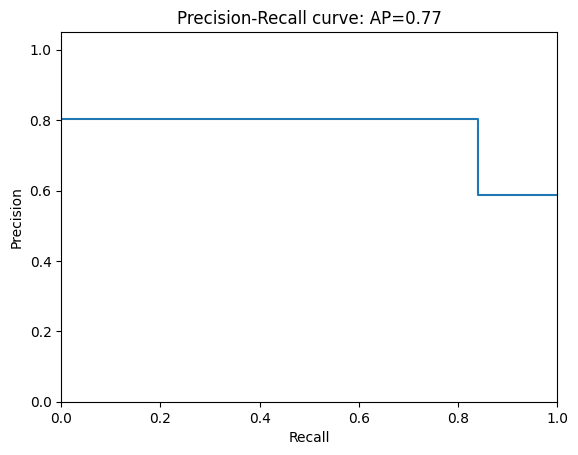

Accuracy: 0.7847642079806529
Precision: 0.8031496062992126
Recall: 0.8395061728395061
F1 Score: 0.8209255533199196
ROC AUC Score: 0.7731255204373484
Average Precision Score: 0.7685658599406231


In [26]:
analyze(proposed_model_with_5_10_th, y_test_5_10_th, X_test_5_10_th)

In [7]:
proposed_model_without_dropout = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
    ),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
    ),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
    ),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(
        128,
        activation="relu",
    ),
    Dense(
        64,
        activation="relu",
    ),
    Dense(
        2,
        activation="softmax",
    ),
])

proposed_model_without_dropout.compile(optimizer=Adam(learning_rate=.1e-3), loss=categorical_crossentropy, metrics=["accuracy"])

In [8]:
proposed_model_without_dropout_history = proposed_model_without_dropout.fit(
    train_datagen_2_10_th,
    epochs=25,
    steps_per_epoch=20,
    batch_size=16,
    validation_data=test_datagen_2_th
)

Epoch 1/25
20/20 [==============================] - 14s 148ms/step - loss: 0.6741 - accuracy: 0.5594 - val_loss: 0.6380 - val_accuracy: 0.6495
Epoch 2/25
20/20 [==============================] - 2s 115ms/step - loss: 0.6287 - accuracy: 0.6406 - val_loss: 0.6197 - val_accuracy: 0.6495
Epoch 3/25
20/20 [==============================] - 2s 118ms/step - loss: 0.5854 - accuracy: 0.6719 - val_loss: 0.5941 - val_accuracy: 0.6737
Epoch 4/25
20/20 [==============================] - 2s 118ms/step - loss: 0.5340 - accuracy: 0.7594 - val_loss: 0.5695 - val_accuracy: 0.6979
Epoch 5/25
20/20 [==============================] - 2s 112ms/step - loss: 0.5354 - accuracy: 0.7375 - val_loss: 0.5174 - val_accuracy: 0.7281
Epoch 6/25
20/20 [==============================] - 2s 112ms/step - loss: 0.5508 - accuracy: 0.7375 - val_loss: 0.5256 - val_accuracy: 0.7523
Epoch 7/25
20/20 [==============================] - 2s 112ms/step - loss: 0.4321 - accuracy: 0.8094 - val_loss: 0.5191 - val_accuracy: 0.7462
Epoch

11/11 [==============================] - 0s 38ms/step
              precision    recall  f1-score   support

           0       0.81      0.54      0.64       142
           1       0.72      0.90      0.80       189

    accuracy                           0.75       331
   macro avg       0.77      0.72      0.72       331
weighted avg       0.76      0.75      0.73       331



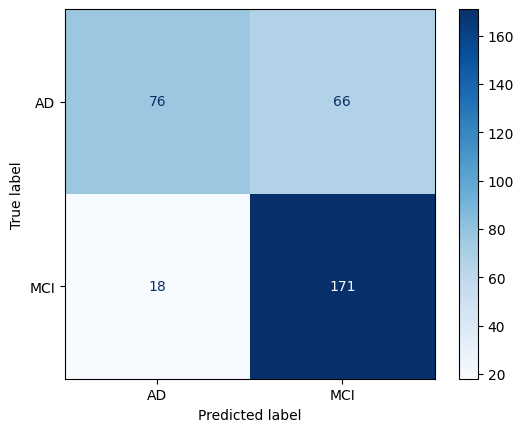

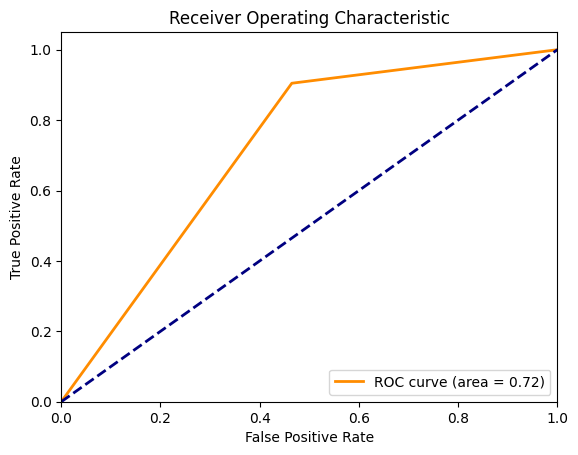

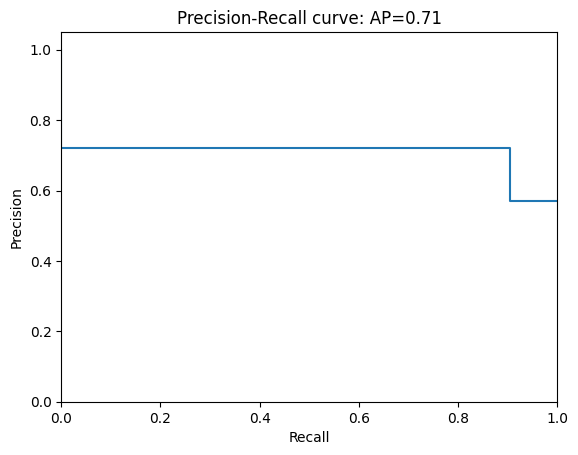

Accuracy: 0.7462235649546828
Precision: 0.7215189873417721
Recall: 0.9047619047619048
F1 Score: 0.8028169014084507
ROC AUC Score: 0.7199865861837692
Average Precision Score: 0.7071835579617903


In [ ]:
analyze(proposed_model_without_dropout, y_test_2_10_th)

In [15]:
proposed_model_without_glorot = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.5),
    Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(
        128,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        64,
        activation="relu",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
    Dropout(0.3),
    Dense(
        2,
        activation="softmax",
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ),
])

proposed_model_without_glorot.compile(optimizer=Adam(learning_rate=.1e-3), loss=categorical_crossentropy, metrics=["accuracy"])

In [16]:
proposed_model_without_glorot_history = proposed_model_without_glorot.fit(
    train_datagen_2_10_th,
    epochs=25,
    steps_per_epoch=50,
    batch_size=16,
    validation_data=test_datagen_2_th
)

Epoch 1/25
50/50 [==============================] - 5s 92ms/step - loss: 4.2825 - accuracy: 0.5761 - val_loss: 3.5538 - val_accuracy: 0.6344
Epoch 2/25
50/50 [==============================] - 4s 89ms/step - loss: 3.2041 - accuracy: 0.6189 - val_loss: 2.9903 - val_accuracy: 0.6284
Epoch 3/25
50/50 [==============================] - 4s 84ms/step - loss: 2.7862 - accuracy: 0.6239 - val_loss: 2.6798 - val_accuracy: 0.6465
Epoch 4/25
50/50 [==============================] - 4s 84ms/step - loss: 2.5137 - accuracy: 0.6415 - val_loss: 2.4558 - val_accuracy: 0.7100
Epoch 5/25
50/50 [==============================] - 4s 83ms/step - loss: 2.3165 - accuracy: 0.6662 - val_loss: 2.2734 - val_accuracy: 0.7190
Epoch 6/25
50/50 [==============================] - 4s 83ms/step - loss: 2.1291 - accuracy: 0.6881 - val_loss: 2.1042 - val_accuracy: 0.7523
Epoch 7/25
50/50 [==============================] - 4s 87ms/step - loss: 1.9811 - accuracy: 0.6956 - val_loss: 1.9797 - val_accuracy: 0.7825
Epoch 8/25
50

11/11 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

           0       0.86      0.66      0.74       126
           1       0.82      0.93      0.87       205

    accuracy                           0.83       331
   macro avg       0.84      0.80      0.81       331
weighted avg       0.83      0.83      0.82       331



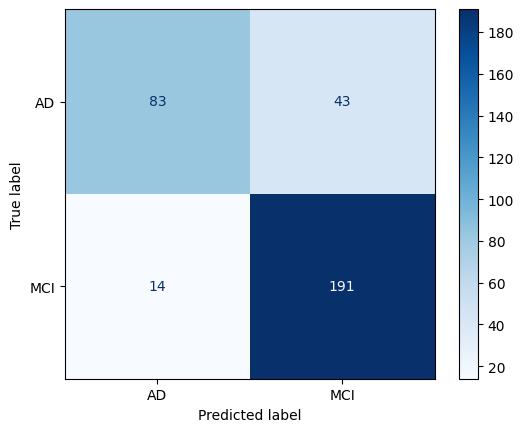

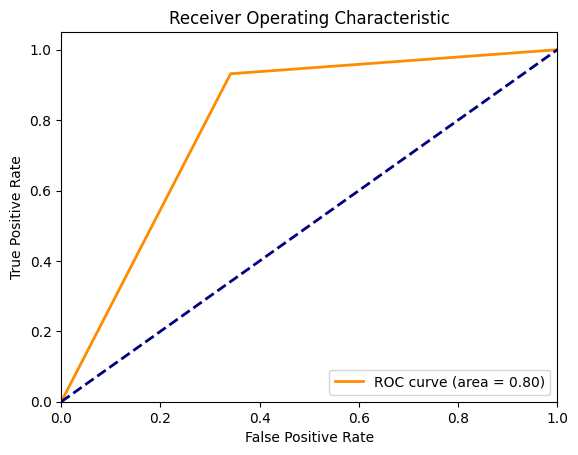

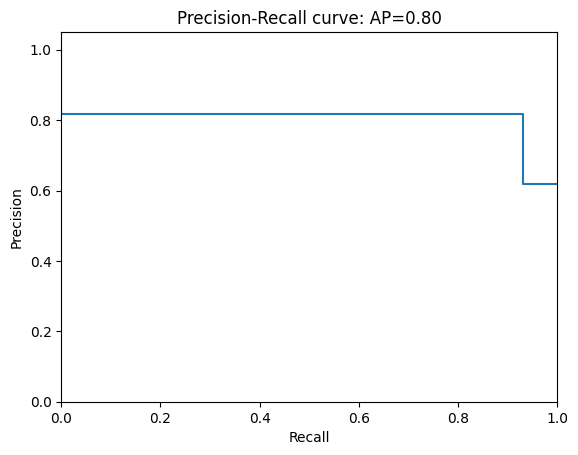

Accuracy: 0.8277945619335347
Precision: 0.8162393162393162
Recall: 0.9317073170731708
F1 Score: 0.8701594533029613
ROC AUC Score: 0.7952187379016646
Average Precision Score: 0.8027922159305255


In [25]:
analyze(proposed_model_without_glorot, y_test_2_10_th)